# Foursquare Data Clustering 

The legend is the following:

International cruising agency Carnival Cruise Line decided to start an advertising campaign using banners. To determine the possible benefit from these banners, in the first stage only 20 of them is going to be placed around the world. 

The cruising agency has 6 offices around the world. The best location for banners (from agency's point of view) is next to offices. These locations should also be popular among tourists.

In order to determine the optimal locations, the [Foursquare database](https://archive.org/details/201309_foursquare_dataset_umn) is used.

To determine the main tourist centers, the coordinates clustering is required to be made. The clustering algorithm should have the cluster limit possibility, and ability to show accurate results without clusters number setting.

### Data Cleaning

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import MeanShift
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# reading the data
data = pd.read_csv('umn_foursquare_datasets/checkins.dat', sep = '|', skipinitialspace = True)
data.columns

Index(['id    ', 'user_id ', 'venue_id ', 'latitude      ', 'longitude     ',
       'created_at      '],
      dtype='object')

In [3]:
# mapping the columns names
mapping = {'id    ' : 'id',
           'user_id ' : 'user_id',
           'venue_id ' : 'venue_id',
           'latitude      ' : 'latitude',
           'longitude     ' : 'longitude',
           'created_at      ' : 'created_at'}

data.columns = data.columns.map(mapping)

In [4]:
# only non-null latitude and longitude values are remained
data = data[data['latitude'].notnull() & data['longitude'].notnull()][['latitude', 'longitude']]

In [5]:
# In order to reduce the clustering algorithm operational time, 100,000 records out of 396,634 are used.
X = data.sample(100000)

In [6]:
# main Offices Coordinates
offices = {'Los Angeles' : [33.751277, -118.188740],
           'Miami' : [25.867736, -80.324116],
           'London' : [51.503016, -0.075479],
           'Amsterdam' : [52.378894, 4.885084],
           'Beijing' : [39.366487, 117.036146],
           'Sydney' : [-33.868457, 151.205134]}

### Clustering the coordinates using `MeanShift` algorithm from `scikit-learn` library

The bandwidth of 0.1 is used, that is equal to 5-10 kms in middle latitudes.

In [7]:
%%time

clustering = MeanShift(bandwidth = .1, n_jobs = -1)
clustering.fit(data)

Wall time: 18min 44s


MeanShift(bandwidth=0.1, n_jobs=-1)

In [8]:
# cluster centers
cl_cntr = clustering.cluster_centers_
cl_cntr.shape[0]

5536

The result of clustering is 5536 clusters.

In [9]:
clusters = pd.Series(clustering.labels_)

# 20 largest clusters
large_clusters_idx = clusters.value_counts()[:20].index.tolist()

In [10]:
# printing the number of objects in each center in the descending order
clusters.value_counts()

0       56187
2       15282
4       10942
1       10895
3        9175
        ...  
5341        1
5425        1
4466        1
4210        1
5503        1
Length: 5536, dtype: int64

In [11]:
# checking the coordinates of the largest center
cl_cntr[0]

array([ 40.71748459, -73.98935883])

The largest cluster (56,187 elements) is New York, US.

Removing the clusters with less than 15 elements.

In [12]:
# number of elements in the aggregated clusters in the descending order
c = clusters.value_counts().values 

# dropping the indexes of clusters with less than 15 elements 
cl_idx = clusters.value_counts().loc[c > 15].index.tolist() 

# number of clusters with more than 15 elements 
len(cl_idx) 

1304

In [13]:
centers = {}
for idx in cl_idx:
    centers[idx] = cl_cntr[idx]

### Obtaining the distances between the centers and offices using `distance.geodesic` method from `geopy` library

In [14]:
off_lat, off_lon, of, ce, di, lon, lat = [], [], [], [], [], [], []

for office in offices:
    off_lat.append(offices[office][0]) 
    off_lon.append(offices[office][1])
    for center in centers:
        of.append(office)
        ce.append(center)
        di.append(geodesic(offices[office], centers[center]).km)
        lat.append(centers[center][0])
        lon.append(centers[center][1])

In [15]:
# putting the data into dataframe
data = pd.DataFrame({'office':of, 'center':ce, 'distance':di, 'longitude':lon, 'latitude':lat})

In [16]:
# printing the top-20 closest centers to offices
top_20 = data.sort_values('distance').reset_index(drop = True).head(20)
top_20

,office,center,distance,longitude,latitude
0,Sydney,251,0.313379,151.207082,-33.866146
1,Amsterdam,319,0.864453,4.892268,52.372489
2,Miami,317,2.711792,-80.311245,25.846206
3,London,55,3.585284,-0.127113,51.503055
4,Los Angeles,48,7.823291,-118.144334,33.811275
5,Miami,24,14.115340,-80.215128,25.787086
6,London,849,16.366937,-0.308323,51.480366
7,Miami,98,19.297080,-80.205598,26.005052
8,Los Angeles,79,20.092696,-118.062259,33.898488
9,London,964,20.107314,-0.321786,51.598314


In this locations the banners can be installed. However, it seems that there is no center closest to Beijing in top-20.

### Plotting the main offices and centers closest to them using `cartopy` library

In [17]:
# obtaining the coordinates of the 20 largest clusters
large_lat, large_lon = [], []
for i in large_clusters_idx:
    large_lat.append(data[data.center == i]['latitude'])
    large_lon.append(data[data.center == i]['longitude'])

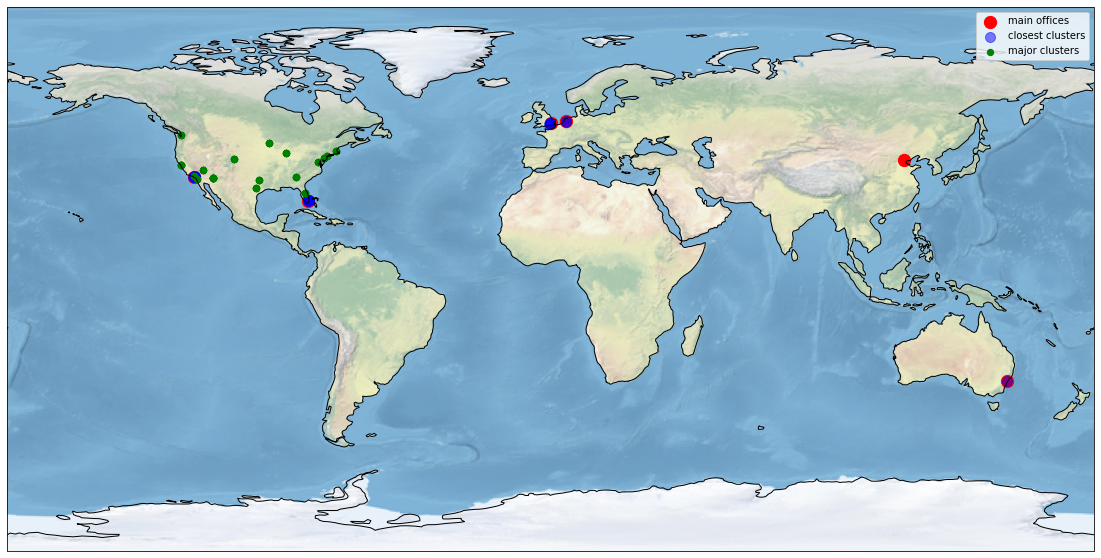

In [18]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(off_lon, off_lat, color = 'red', s = 150, label = 'main offices')
ax.scatter(top_20.longitude, top_20.latitude, color = 'blue', alpha = 0.5, s = 100, label = 'closest clusters')

ax.scatter(large_lon, large_lat, color = 'green', s = 40, label = 'major clusters')
ax.coastlines()
ax.stock_img()
plt.legend()
plt.show()

As it can be seen from the map above, all the main offices (except from Beijing) have clusters that are located in the same city (LA, Miami, London, Amsterdam, Sydney).

The 20 largest clusters are located in the U.S.

### Counting the number of centers from top-20 closest to offices

In [19]:
data.sort_values('distance').reset_index(drop = True).head(20)['office'].value_counts()

Los Angeles    7
Miami          6
London         4
Amsterdam      2
Sydney         1
Name: office, dtype: int64

Unfortunately, there is no center close to Beijing in the top-20 closest centers.

### Determining the center closest to Beijing

In [20]:
data[data.office == 'Beijing'].sort_values('distance')

,office,center,distance,longitude,latitude
5643,Beijing,427,80.483274,116.407413,39.904214
6114,Beijing,901,870.220179,126.705206,37.456256
5501,Beijing,285,889.890144,126.978281,37.566110
5649,Beijing,437,988.439781,121.473704,31.230393
6151,Beijing,941,1641.320308,121.550757,25.065852
...,...,...,...,...,...
6134,Beijing,927,18524.837246,-51.228735,-30.027704
6466,Beijing,1245,18969.491010,-71.616452,-33.050462
5636,Beijing,421,19066.782037,-70.570008,-33.425197
6447,Beijing,1247,19343.457040,-58.510679,-34.524128


# Conclusion

As the result, the top-20 optimal locations were obtained. The biggest number of banners can be placed in LA, California and Miami, Florida (7 and 6 respectively); the remaining 7 banners can be installed in Amsterdam (3 banners), London (2 banners), Sydney and Beijing (1 banners in each city). 